In [1]:
import sklearn
from sklearn.datasets import fetch_20newsgroups, fetch_20newsgroups_vectorized
import numpy as np
import scipy as scp
from scipy import sparse

NUM_SAMPLES = 200
LARGE_VAL = 10000000
ITER_THRESH = 5

In [2]:
#A function to get the 20 newsgroup data
def get_data():
    #news_groups_all = fetch_20newsgroups(subset='all')
    #news_data = news_groups_all.data

    #Load in the vectorized news group data from scikit-learn package
    vectorized_news = fetch_20newsgroups_vectorized(subset='all')
    all_data = vectorized_news.data
    all_targets = np.array(vectorized_news.target)
    class_names = vectorized_news.target_names

    #Set class pairings as described in the multiview clustering paper
    class_pairs = [['comp.graphics', 'rec.autos'],['rec.motorcycles', 'sci.med'], ['sci.space', 'misc.forsale'], ['rec.sport.hockey', 'soc.religion.christian'], ['comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc']]

    #Create lists to hold data and labels for each of the 5 class across 2 different views
    labels =  [num for num in range(len(class_pairs)) for _ in range(NUM_SAMPLES)]
    labels = np.array(labels)
    view1_data = list()
    view2_data = list()
    views_data = [view1_data, view2_data]
    
    #Randomly sample 200 items from each of the selected classes in each pair
    for ind1 in range(len(class_pairs)):
        for ind2 in range(len(class_pairs[0])):
            class_num = class_names.index(class_pairs[ind1][ind2])
            class_data = all_data[(all_targets == class_num)]
            indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
            views_data[ind2].append(class_data[indices])

    #Shuffle and normalize vectors
    shuffled_inds = np.random.permutation(NUM_SAMPLES * len(class_pairs))
    view1_data = sparse.vstack(view1_data)
    view2_data = sparse.vstack(view2_data)
    view1_data = np.array(view1_data[shuffled_inds].todense())
    view2_data = np.array(view2_data[shuffled_inds].todense())
    magnitudes1 = np.linalg.norm(view1_data, axis=1)
    magnitudes2 = np.linalg.norm(view2_data, axis=1)
    magnitudes1[magnitudes1 == 0] = 1
    magnitudes2[magnitudes2 == 0] = 1
    magnitudes1 = magnitudes1.reshape((-1,1))
    magnitudes2 = magnitudes2.reshape((-1,1))
    view1_data /= magnitudes1
    view2_data /= magnitudes2
    labels = labels[shuffled_inds]
    
    return view1_data, view2_data, labels


In [3]:
#Function to initialize partitions
def initialize_partitions(data, c_centers):
    cosine_sims = np.matmul(data, np.transpose(c_centers))
    new_partitions = np.argmax(cosine_sims,axis = 1).flatten()
    return new_partitions

#A function to compute the value of the objective function
def compute_objective(data, c_centers, partitions):

    o_funct = 0
    for clust in range(c_centers.shape[0]):
        vecs = data[(partitions == clust)]
        dot_products = np.matmul(vecs, c_centers[clust].transpose())
        clust_sum = np.sum(1 - dot_products)
        o_funct += clust_sum
    return o_funct


#A function to run through a single iteration of maximization and expectation
#(in that order)
def iterate_clusters(data, partitions, k):

    #Recompute cluster centers
    new_centers = list()
    for clust in range(k):
        #print(np.sum(partitions == clust))
        summed_vec = np.sum(data[(partitions == clust)], axis = 0)
        magnitude = np.linalg.norm(summed_vec)
        if (magnitude == 0):
            magnitude = 1
        vec = summed_vec / magnitude 
        new_centers.append(vec)
    new_centers = np.vstack(new_centers)
        
    #Assign each sample point to a partition
    cosine_sims = np.matmul(data, np.transpose(new_centers))
    new_partitions = np.argmax(cosine_sims,axis = 1).flatten()

    return new_centers, new_partitions


In [4]:
#A function to consolidate the final clusters from the two views
def final_clusters(v_data, v_partitions, c_centers, k):

    v1_consensus = list()
    v2_consensus = list()
    for clust in range(k):
        part_indices = (v_partitions[0] == clust) * (v_partitions[1] == clust)
        #View 1
        summed_vec1 = np.sum(v_data[0][part_indices], axis = 0)
        magnitudes1 =  np.linalg.norm(summed_vec1)
        if(magnitudes1 == 0):
            magnitudes1 = 1
        vec1 = summed_vec1 / magnitudes1
        v1_consensus.append(vec1)

        #View 2
        summed_vec2 = np.sum(v_data[1][part_indices], axis = 0) 
        magnitudes2 =  np.linalg.norm(summed_vec2)
        if(magnitudes2 == 0):
            magnitudes2 = 1
        vec2 = summed_vec2 / magnitudes2
        v2_consensus.append(vec2)
        
    v1_consensus = np.vstack(v1_consensus)
    v2_consensus = np.vstack(v2_consensus)
        
    v1_arcos = np.arccos(np.matmul(v_data[0], np.transpose(v1_consensus)))
    v2_arcos = np.arccos(np.matmul(v_data[1], np.transpose(v2_consensus)))
    dist_metric = v1_arcos + v2_arcos
    new_partitions = np.argmin(dist_metric,axis = 1).flatten()
    return new_partitions

In [5]:
#A function to evaluate the quality of the clustering via an entropy metric
def compute_entropy(partitions, labels, k, num_classes):
    class_sizes = list()
    for ind in range(num_classes):
        class_sizes.append(np.sum(labels == ind))
    total_entropy = 0
    num_examples = partitions.shape[0]
    for part in range(k):
        labs = labels[partitions == part]
        part_size = labs.shape[0]
        part_entropy = 0
        for cl in range(num_classes):
            prop = np.sum(labs == cl) * 1.0 / class_sizes[cl]
            ent = 0
            if(prop != 0):
                ent = - prop * np.log(prop)
            part_entropy += ent
        part_entropy = part_entropy * part_size / num_examples
        total_entropy += part_entropy
    return total_entropy

def compute_entropy2(partitions, labels, k, num_classes):
    
    total_entropy = 0
    num_examples = partitions.shape[0]
    for part in range(k):
        labs = labels[partitions == part]
        part_size = labs.shape[0]
        part_entropy = 0
        for cl in range(num_classes):
            prop = np.sum(labs == cl) * 1.0 / part_size
            ent = 0
            if(prop != 0):
                ent = - prop * np.log2(prop)
            part_entropy += ent
        part_entropy = part_entropy * part_size / num_examples
        total_entropy += part_entropy
    return total_entropy

In [6]:
#The main kmeans clustering algorithm
def spherical_kmeans(v_data, labels, k = 5):

    #Initialize cluster centers, partitions, and loop params
    
    c_centers2 = np.random.random((k, v_data[0].shape[1]))
    c_centers2 /= np.linalg.norm(c_centers2, axis=1).reshape((-1, 1))
    c_centers = [None, c_centers2]
    
    partitions2 = initialize_partitions(v_data[1], c_centers2)
    v_partitions = [None, partitions2]
    objective = [LARGE_VAL, LARGE_VAL]
    iter_stall = 0
    iter_num = 0
    entropy = 0

    while(iter_stall < ITER_THRESH):
        iter_num += 1
        view = (iter_num + 1) % 2
        
        #Switch partitions, Maximization, and Expectation
        c_centers[view], v_partitions[view] = iterate_clusters(v_data[view], v_partitions[(view + 1) % 2], k)
        o_funct = compute_objective(v_data[view], c_centers[view], v_partitions[view])
        iter_stall += 1
        #Recompute objective function
        if(o_funct < objective[view]):
            objective[view] = o_funct
            iter_stall = 0

        #Obtain evaluation metrics
        f_clusters = final_clusters(v_data, v_partitions, c_centers, k)
        entropy = compute_entropy2(f_clusters, labels, k, 5)

    return entropy
        

In [10]:
def getEntropies():
    
    v1_data, v2_data, labels = get_data()
    entropies = list()
    for num in range(1, 11):
        ent = spherical_kmeans([v1_data, v2_data], labels, num)
        entropies.append(ent)
    return entropies

def getSingleEntropies():
    
    v1_data, v2_data, labels = get_data()
    entropies = list()
    for num in range(1, 11):
        ent = single_spherical_kmeans([v1_data, v2_data], labels, num)
        entropies.append(ent)
        print(ent)
    return entropies

In [8]:
#Get data
v1_data, v2_data, labels = get_data()

#Do spherical kmeans and get entropy values for each k
entropies = getEntropies()
print(entropies)

[2.321928094887362, 1.9954240390008535, 1.6511840631006303, 1.5276184212068493, 1.368600094620235, 1.3049866418663225, 1.3301706995752531, 1.2461633576226545, 1.180925436043731, 1.211023377173696]


In [13]:
def single_spherical_kmeans(v_data, labels, k = 5):

    #Initialize cluster centers, partitions, and loop params
    v_data = np.concatenate(v_data, axis = 1)
    c_centers = np.random.random((k, v_data.shape[1]))
    partitions = initialize_partitions(v_data, c_centers)
    objective = LARGE_VAL
    iter_stall = 0
    iter_num = 0
    entropy = 0

    while(iter_stall < ITER_THRESH):
        iter_num += 1
        
        #Switch partitions, Maximization, and Expectation
        c_centers, partitions = iterate_clusters(v_data, partitions, k)
        o_funct = compute_objective(v_data, c_centers, partitions)
        iter_stall += 1
        
        #Recompute objective function
        if(o_funct < objective):
            objective = o_funct
            iter_stall = 0

        #Obtain evaluation metrics
        entropy = compute_entropy2(partitions, labels, k, 5)
    
    return entropy

In [14]:
#Do spherical kmeans and get entropy values for each k
entropies_single = getSingleEntropies()

2.321928094887362
2.1286784049515886
2.021247928888088
2.0126274258075196
2.0096539840333825
1.8911510445766857
1.9644350404412847
1.9248442448393377
1.84731806236203
1.8135226622910483


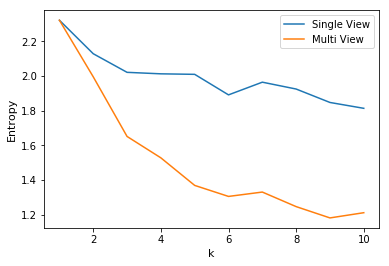

In [44]:
import matplotlib.pyplot as plt
x_values = list(range(1, 11))
plt.plot(x_values, entropies_single, x_values, entropies)
plt.xlabel('k')
plt.ylabel('Entropy')
plt.legend(['Single View', 'Multi View'])
plt.rc('axes', labelsize=12)
plt.show()